In [1]:
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

import numpy as np

from tqdm import tqdm

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pytorch_utils import *
from pytorch_models import *
from utils import load_sequences, print_predictions
from conlleval import main as conll_eval


sns.set_context("poster")
sns.set_style("ticks")

In [2]:
TRAIN_CORPUS="data/conll2000/train.txt"
TEST_CORPUS="data/conll2000/test.txt"

In [3]:
train_corpus = load_sequences(TRAIN_CORPUS, sep=" ", col_ids=(0, -1))
train_corpus, dev_corpus = train_corpus[100:], train_corpus[:100]
print("Total items in train corpus: %s" % len(train_corpus))
print("Total items in dev corpus: %s" % len(dev_corpus))
test_corpus = load_sequences(TEST_CORPUS, sep=" ", col_ids=(0, -1))
print("Total items in test corpus: %s" % len(test_corpus))

Total items in train corpus: 8836
Total items in dev corpus: 100
Total items in test corpus: 2012


In [4]:
train_corpus[0]

[('He', 'B-NP'),
 ('talked', 'B-VP'),
 ('about', 'B-NP'),
 ('20', 'I-NP'),
 ('minutes', 'I-NP'),
 ('.', 'O')]

In [5]:
def create_vocab(data, vocabs, char_vocab, word_idx=0):
    n_vocabs = len(vocabs)
    for sent in data:
        for token_tags in sent:
            for vocab_id in range(n_vocabs):
                vocabs[vocab_id].add(token_tags[vocab_id])
            char_vocab.batch_add(token_tags[word_idx])
    print("Created vocabs: %s, chars[%s]" % (", ".join(
        "{}[{}]".format(vocab.name, vocab.size)
        for vocab in vocabs
    ), char_vocab.size))

In [6]:
word_vocab = Vocab("words", UNK="UNK")
char_vocab = Vocab("chars", UNK="<U>")
ner_vocab = Vocab("ner_tags")

create_vocab(train_corpus+dev_corpus+test_corpus, [word_vocab, ner_vocab], char_vocab)

Created vocabs: words[21590], ner_tags[23], chars[81]


In [7]:
def data2tensors(data, vocabs, char_vocab, word_idx=0, column_ids=(0, -1)):
    vocabs = [vocabs[idx] for idx in column_ids]
    n_vocabs = len(vocabs)
    tensors = []
    char_tensors = []
    for sent in data:
        sent_vecs = [[] for i in range(n_vocabs+1)] # Last is for char vecs
        char_vecs = []
        for token_tags in sent:
            for vocab_id in range(n_vocabs):
                sent_vecs[vocab_id].append(
                    vocabs[vocab_id].getidx(token_tags[vocab_id])
                )
            sent_vecs[-1].append(
                [char_vocab.getidx(c) for c in token_tags[word_idx]]
            )
        tensors.append(sent_vecs)
    return tensors

In [8]:
train_tensors = data2tensors(train_corpus, [word_vocab, ner_vocab], char_vocab)
dev_tensors = data2tensors(dev_corpus, [word_vocab, ner_vocab], char_vocab)
test_tensors = data2tensors(test_corpus, [word_vocab, ner_vocab], char_vocab)
print("Train: {}, Dev: {}, Test: {}".format(
    len(train_tensors),
    len(dev_tensors),
    len(test_tensors),
))

Train: 8836, Dev: 100, Test: 2012


In [9]:
def plot_losses(train_losses, eval_losses=None, plot_std=False, ax=None):
    if ax is None:
        ax = plt.gca()
    for losses, color, label in zip(
        [train_losses, eval_losses],
        ["0.5", "r"],
        ["Train", "Eval"],
    ):
        mean_loss, std_loss = zip(*losses)
        mean_loss = np.array(mean_loss)
        std_loss = np.array(std_loss)
        ax.plot(
            mean_loss, color=color, label=label,
            linestyle="-", 
        )
        if plot_std:
            ax.fill_between(
                np.arange(mean_loss.shape[0]),
                mean_loss-std_loss,
                mean_loss+std_loss,
                color=color,
                alpha=0.3
            )
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Mean Loss ($\pm$ S.D.)")
    
    
def print_predictions(corpus, predictions, filename, label_vocab):
    with open(filename, "w+") as fp:
        for seq, pred in zip(corpus, predictions):
            for (token, true_label), pred_label in zip(seq, pred):
                pred_label = label_vocab.idx2item[pred_label]
                print("{}\t{}\t{}".format(token, true_label, pred_label), file=fp)
            print(file=fp) # Add new line after each sequence

In [10]:
char_emb_size=10
output_channels=25
kernel_sizes=[2, 3]
char_embedding = CharEmbedding(char_vocab.size, char_emb_size, output_channels, kernel_sizes)

In [11]:
char_embedding(Variable(torch.LongTensor([[1,1,2,3]]), requires_grad=False))

Variable containing:

Columns 0 to 9 
 0.0000  3.4354  0.0000  0.0000  2.6089  0.0000  2.2081  0.0000  3.0193  0.3947

Columns 10 to 19 
 0.0000  0.0000  0.0000  0.0000  0.8294  0.0000  0.0000  0.0000  0.0000  0.0000

Columns 20 to 29 
 0.0000  0.0000  0.0000  2.2640  0.0000  2.1755  5.2433  1.7468  0.0000  0.0000

Columns 30 to 39 
 0.0000  4.2533  0.0000  0.0000  0.0000  0.0000  0.0000  2.0339  1.0762  4.5157

Columns 40 to 49 
 1.7377  0.0000  0.0000  0.2469  0.0000  0.0000  0.3585  5.5818  0.0000  0.0000
[torch.FloatTensor of size 1x50]

In [12]:
word_emb_size=50
char_embed_kwargs=dict(
    vocab_size=char_vocab.size,
    embedding_size=char_emb_size,
    out_channels=output_channels,
    kernel_sizes=kernel_sizes
)
word_char_embedding = WordCharEmbedding(
    word_vocab.size, word_emb_size, char_embed_kwargs, dropout=0.2)

In [13]:
def charseq2varlist(X_chars):
    return [Variable(torch.LongTensor([x]), requires_grad=False) for x in X_chars]

In [14]:
print(len(train_tensors[0][0]))
print(len(train_tensors[0][-1]))

6
6


In [15]:
train_corpus[0]

[('He', 'B-NP'),
 ('talked', 'B-VP'),
 ('about', 'B-NP'),
 ('20', 'I-NP'),
 ('minutes', 'I-NP'),
 ('.', 'O')]

In [16]:
charseq2varlist(train_tensors[0][-1])

[Variable containing:
  1  2
 [torch.LongTensor of size 1x2], Variable containing:
  3  4  5  6  2  7
 [torch.LongTensor of size 1x6], Variable containing:
   4   8   9  10   3
 [torch.LongTensor of size 1x5], Variable containing:
  11  12
 [torch.LongTensor of size 1x2], Variable containing:
    13    14    15    10     3     2    16
 [torch.LongTensor of size 1x7], Variable containing:
  17
 [torch.LongTensor of size 1x1]]

In [17]:
word_char_embedding(
    Variable(torch.LongTensor([train_tensors[0][0]]), requires_grad=False),
    charseq2varlist(train_tensors[0][-1])
).size()

torch.Size([1, 6, 50])

## Class based

In [18]:
class ModelWrapper(object):
    def __init__(self, model,
                 loss_function,
                 use_cuda=False
                ):
        self.model = model
        self.loss_function = loss_function

        self.use_cuda = use_cuda
        if self.use_cuda:
            self.model.cuda()
        
    def _process_instance_tensors(self, instance_tensors):
        raise NotImplementedError("Please define this function explicitly")
        
    def zero_grad(self):
        self.model.zero_grad()
        
    def get_parameters(self):
        return self.model.paramerters()
    
    def set_model_mode(self, training_mode=True):
        if training_mode:
            self.model.train()
        else:
            self.model.eval()
            
    def save(self, filename):
        torch.save(self.model, filename)
        print("{} model saved to {}".format(self.model.__class__, filename))
        
    def load(self, filename):
        self.model = torch.load(filename)
        if self.use_cuda:
            self.model.cuda()

    def get_instance_loss(self, instance_tensors, zero_grad=True):
        if zero_grads:
        ## Clear gradients before every update else memory runs out
            self.zero_grad()
        raise NotImplementedError("Please define this function explicitly")
        
    def predict(self, instance_tensors):
        raise NotImplementedError("Please define this function explicitly")
        
    def predict_batch(self, batch_tensors):
        predictions = []
        for instance_tensors in batch_tensors:
            predictions.append(self.predict(instance_tensors))
        return predictions
        
        
def get_epoch_function(model_wrapper, optimizer,
                       use_cuda=False):
    def perform_epoch(data_tensors, training_mode=True, batch_size=1):
        model_wrapper.set_model_mode(training_mode)
        step_losses = []
        data_tensors = np.random.permutation(data_tensors)
        n_splits = data_tensors.shape[0]//batch_size
        for batch_tensors in np.array_split(data_tensors, n_splits):
            #from IPython.core.debugger import Tracer; Tracer()()
            model_wrapper.zero_grad()
            loss = Variable(torch.FloatTensor([0.]))
            if use_cuda:
                loss = loss.cuda()
            for instance_tensors in batch_tensors:
                loss += model_wrapper.get_instance_loss(instance_tensors, zero_grad=False)
            loss = loss/batch_tensors.shape[0] # Mean loss
            step_losses.append(loss.data[0])
            if training_mode:
                ## Get gradients of model params wrt. loss
                loss.backward()
                ## Optimize the loss by one step
                optimizer.step()
        return step_losses
    return perform_epoch

def training_wrapper(
    model_wrapper, data_tensors,
    eval_tensors=None,
    optimizer=optim.SGD,
    optimizer_kwargs=None,
    n_epochs=10,
    batch_size=1,
    use_cuda=False):
    """Wrapper to train the model
    """
    if optimizer_kwargs is None:
        optimizer_kwargs = {}
    optimizer=optimizer(model_wrapper.model.parameters(), **optimizer_kwargs)
    # Start training
    losses = []
    eval_losses = []
    data_tensors = np.array(data_tensors)
    if eval_tensors is not None:
        eval_tensors = np.array(eval_tensors)
    perform_epoch = get_epoch_function(
        model_wrapper,
        optimizer,
        use_cuda=use_cuda)
    for epoch in tqdm(range(n_epochs)):
        step_losses = perform_epoch(data_tensors, batch_size=batch_size)
        losses.append((np.mean(step_losses), np.std(step_losses)))
        if eval_tensors is not None:
            step_losses = perform_epoch(eval_tensors, training_mode=False)
            eval_losses.append((np.mean(step_losses), np.std(step_losses)))
    return {
        "training_loss": losses,
        "evaluation_loss": eval_losses
    }        

In [19]:
class LSTMTaggerModel(ModelWrapper):
    def __init__(self, model,
                 loss_function,
                 use_cuda=False):
        self.model = model
        self.loss_function = loss_function

        self.use_cuda = use_cuda
        if self.use_cuda:
            #[k.cuda() for k in self.model.modules()]
            self.model.cuda()
        
    def _process_instance_tensors(self, instance_tensors):
        X, Y, X_char = instance_tensors
        X = Variable(torch.LongTensor([X]), requires_grad=False)
        Y = Variable(torch.LongTensor(Y), requires_grad=False)
        X_char = charseq2varlist(X_char)
        if self.use_cuda:
            X = X.cuda()
            Y = Y.cuda()
            X_char = [t.cuda() for t in X_char]
        return X, X_char, Y

    def get_instance_loss(self, instance_tensors, zero_grad=True):
        if zero_grad:
            ## Clear gradients before every update else memory runs out
            self.model.zero_grad()
        X, X_char, Y = self._process_instance_tensors(instance_tensors)
        #print(X.get_device(), [t.get_device() for t in X_char])
        return self.loss_function(self.model.forward(X, X_char), Y)
        
    def predict(self, instance_tensors):
        X, X_char, Y = self._process_instance_tensors(instance_tensors)
        prediction = self.model.forward(X, X_char)
        return prediction.data.cpu().max(1)[1].numpy().ravel()

In [20]:
n_epochs=5
use_cuda=True
n_embed=50
hidden_size=20
batch_size=10

char_emb_size=10
output_channels=25
kernel_sizes=[2, 3]

word_emb_size=50
char_embed_kwargs=dict(
    vocab_size=char_vocab.size,
    embedding_size=char_emb_size,
    out_channels=output_channels,
    kernel_sizes=kernel_sizes
)

word_char_embedding = WordCharEmbedding(
        word_vocab.size, word_emb_size,
        char_embed_kwargs, dropout=0.2)

model_wrapper = LSTMTaggerModel(
    LSTMTaggerWordChar(word_char_embedding, n_embed, hidden_size, ner_vocab.size),
    nn.NLLLoss(), use_cuda=use_cuda)

In [21]:
model_wrapper.get_instance_loss(train_tensors[0])

Variable containing:
 3.1844
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [22]:
len(list(model_wrapper.model.parameters()))

16

In [23]:
training_history = training_wrapper(
    model_wrapper, train_tensors, 
    eval_tensors=dev_tensors,
    optimizer=optim.Adam,
    optimizer_kwargs={
        #"lr": 0.01,
        "weight_decay": 0.5
    },
    n_epochs=n_epochs,
    batch_size=batch_size,
    use_cuda=use_cuda)
model_wrapper.save("LSTMTaggerModel_CONLL2000")

100%|██████████| 5/5 [30:50<00:00, 367.10s/it]

<class 'pytorch_models.LSTMTaggerWordChar'> model saved to LSTMTaggerModel_CONLL2000


In [24]:
preds = model_wrapper.predict(train_tensors[0])
preds

array([2, 2, 2, 2, 2, 2])

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


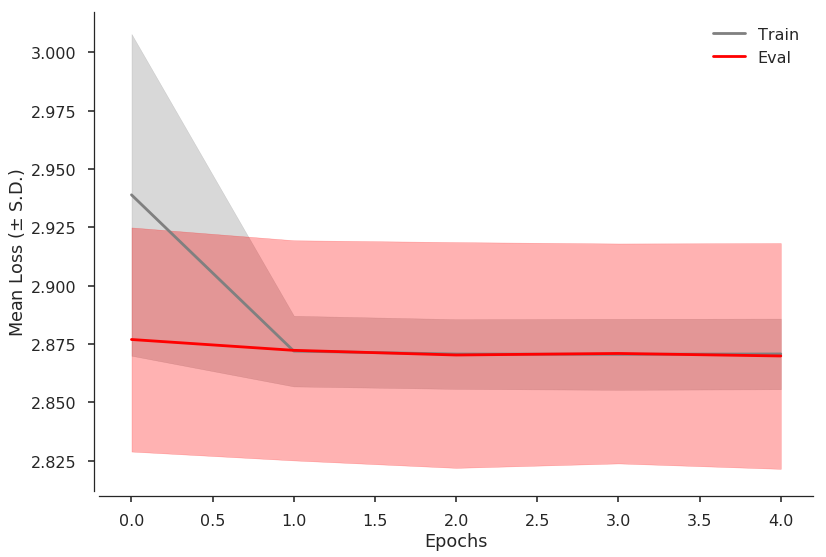

In [25]:
fig, ax = plt.subplots(1,1)
plot_losses(training_history["training_loss"],
            training_history["evaluation_loss"],
            plot_std=True,
            ax=ax)
ax.legend()
sns.despine(offset=5)

In [26]:
for title, tensors, corpus in zip(
    ["train", "dev", "test"],
    [train_tensors, dev_tensors, test_tensors],
    [train_corpus, dev_corpus, test_corpus],
                         ):
    %time predictions = model_wrapper.predict_batch(tensors)
    print_predictions(corpus, predictions, "%s.chunking.conll" % title, ner_vocab)
    conll_eval(["conlleval", "%s.chunking.conll" % title])

CPU times: user 2min 58s, sys: 276 ms, total: 2min 58s
Wall time: 2min 58s
processed 209287 tokens with 105732 phrases; found: 8836 phrases; correct: 33.
accuracy:  29.90%; precision:   0.37%; recall:   0.03%; FB1:   0.06
             ADJP: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
             ADVP: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            CONJP: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
             INTJ: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              LST: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
               NP: precision:   0.37%; recall:   0.06%; FB1:   0.10  8836
               PP: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              PRT: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
             SBAR: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              UCP: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
               VP: precision:   0.00%; recall:   0.00%; FB1:   0.

## CRF model

In [27]:
class BiLSTMTaggerWordCRFModel(ModelWrapper):
    def __init__(self, model,
                 loss_function,
                 use_cuda=False):
        self.model = model
        self.loss_function = None

        self.use_cuda = use_cuda
        if self.use_cuda:
            #[k.cuda() for k in self.model.modules()]
            self.model.cuda()
        
    def _process_instance_tensors(self, instance_tensors):
        X, Y, X_char = instance_tensors
        X = Variable(torch.LongTensor([X]), requires_grad=False)
        Y = torch.LongTensor(Y)
        X_char = charseq2varlist(X_char)
        if self.use_cuda:
            X = X.cuda()
            Y = Y.cuda()
            X_char = [t.cuda() for t in X_char]
        return X, X_char, Y

    def get_instance_loss(self, instance_tensors, zero_grad=True):
        if zero_grad:
            ## Clear gradients before every update else memory runs out
            self.model.zero_grad()
        X, X_char, Y = self._process_instance_tensors(instance_tensors)
        #print(X.get_device(), [t.get_device() for t in X_char])
        return self.model.loss(X, X_char, Y)
        
    def predict(self, instance_tensors):
        X, X_char, Y = self._process_instance_tensors(instance_tensors)
        emissions = self.model.forward(X, X_char)
        return self.model.crf.forward(emissions)[1]


In [28]:
n_epochs=5
use_cuda=True
n_embed=50
hidden_size=20
batch_size=10

char_emb_size=10
output_channels=25
kernel_sizes=[2, 3]

word_emb_size=50
char_embed_kwargs=dict(
    vocab_size=char_vocab.size,
    embedding_size=char_emb_size,
    out_channels=output_channels,
    kernel_sizes=kernel_sizes
)

word_char_embedding = WordCharEmbedding(
        word_vocab.size, word_emb_size,
        char_embed_kwargs, dropout=0.2)

model_wrapper = BiLSTMTaggerWordCRFModel(
    LSTMTaggerWordCharCRF(word_char_embedding, n_embed, hidden_size, ner_vocab.size),
    None, use_cuda=use_cuda)

In [29]:
training_history = training_wrapper(
    model_wrapper, train_tensors, 
    eval_tensors=dev_tensors,
    optimizer=optim.Adam,
    optimizer_kwargs={
        #"lr": 0.01,
        "weight_decay": 0.5
    },
    n_epochs=n_epochs,
    batch_size=batch_size,
    use_cuda=use_cuda)
model_wrapper.save("BiLSTMTaggerWordCRFModel_CONLL2000")

100%|██████████| 5/5 [45:06<00:00, 540.50s/it]

<class 'pytorch_models.LSTMTaggerWordCharCRF'> model saved to BiLSTMTaggerWordCRFModel_CONLL2000


/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


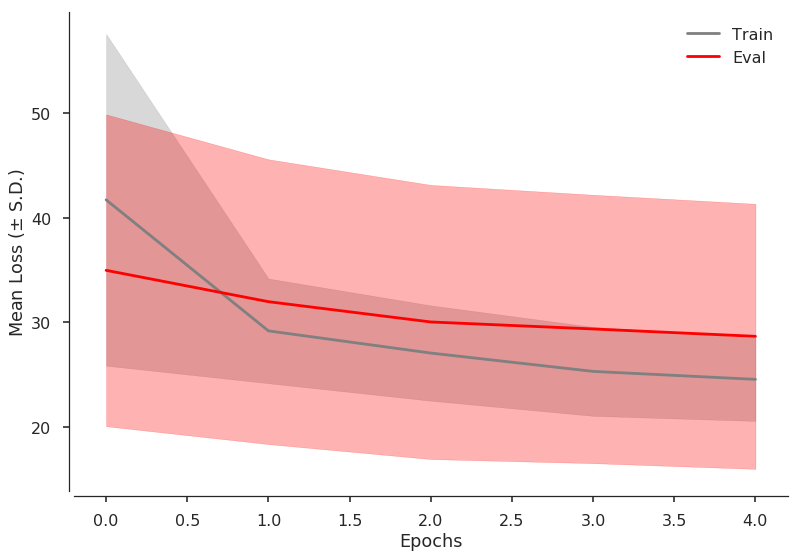

In [30]:
fig, ax = plt.subplots(1,1)
plot_losses(training_history["training_loss"],
            training_history["evaluation_loss"],
            plot_std=True,
            ax=ax)
ax.legend()
sns.despine(offset=5)

In [31]:
for title, tensors, corpus in zip(
    ["train", "dev", "test"],
    [train_tensors, dev_tensors, test_tensors],
    [train_corpus, dev_corpus, test_corpus],
                         ):
    %time predictions = model_wrapper.predict_batch(tensors)
    print_predictions(corpus, predictions, "%s.chunking.conll" % title, ner_vocab)
    conll_eval(["conlleval", "%s.chunking.conll" % title]) 

CPU times: user 3min 6s, sys: 456 ms, total: 3min 6s
Wall time: 3min 7s
processed 209287 tokens with 105732 phrases; found: 81889 phrases; correct: 41478.
accuracy:  66.40%; precision:  50.65%; recall:  39.23%; FB1:  44.21
             ADJP: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
             ADVP: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            CONJP: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
             INTJ: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              LST: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
               NP: precision:  43.10%; recall:  42.88%; FB1:  42.99  54179
               PP: precision:  65.89%; recall:  84.86%; FB1:  74.18  27079
              PRT: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
             SBAR: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              UCP: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
               VP: precision:  44.69%; recall:   1.33%; FB1